<p style="font-size:36px;text-align:center"> <b>Walmart Recruiting</b> </p>

<b>Data Description</b>

You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

<b>stores.csv</b>

This file contains anonymized information about the 45 stores, indicating the type and size of store.

<b>train.csv</b>

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

    Store - the store number
    Dept - the department number
    Date - the week
    Weekly_Sales -  sales for the given department in the given store
    IsHoliday - whether the week is a special holiday week

<b>test.csv</b>

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

<b>features.csv</b>

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

    Store - the store number
    Date - the week
    Temperature - average temperature in the region
    Fuel_Price - cost of fuel in the region
    MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
    CPI - the consumer price index
    Unemployment - the unemployment rate
    IsHoliday - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [1]:
ls

features.csv          stores.csv  train.csv
sampleSubmission.csv  test.csv    Walmart Recruiting.ipynb


References 
https://www.kaggle.com/yepp2411/walmart-prediction-1-eda-with-time-and-space


https://www.kaggle.com/jevonlee001/walmat-rfr

# Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

# Reading Stores Data

In [3]:
df=pd.read_csv("stores.csv")
df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
df.shape

(45, 3)

In [5]:
df.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


# Reading Features Data

In [6]:
df_fts=pd.read_csv("features.csv")
df_fts.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


Note: MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.

In [7]:
df_fts.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


Observation: We can see here that a negative markdown value exists,which shouldn't be the case hence we need to remove all values <0

In [8]:
df_fts["MarkDown1"][df_fts["MarkDown1"]<0]=0
df_fts["MarkDown2"][df_fts["MarkDown2"]<0]=0
df_fts["MarkDown3"][df_fts["MarkDown3"]<0]=0
df_fts["MarkDown5"][df_fts["MarkDown5"]<0]=0

In [9]:
df_fts.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7033.397205,3384.393567,1760.211982,3292.935886,4132.271284,172.460809,7.826821
std,12.987966,18.678607,0.431337,9261.852799,8793.497335,11276.444212,6792.329861,13086.672614,39.738346,1.877259
min,1.000000,-7.290000,2.472000,0.000000,0.000000,0.000000,0.220000,0.000000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


# Reading Train Data

In [10]:
df_train=pd.read_csv("train.csv")
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [11]:
df_train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


Observation: Again Weekly_sales cannot have a negative value.

In [12]:
df_train["Weekly_Sales"][df_train["Weekly_Sales"]<0]=0

In [13]:
df_train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.467250
std,12.785297,30.492054,22711.032446
min,1.000000,1.000000,0.000000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


# Reading Test Data

In [14]:
df_test=pd.read_csv("test.csv")
df_test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


# Merging Train+Store+Features

In [15]:
df_full=pd.merge(df_train,df,how='left',on='Store').merge(df_fts,how='inner',on=['Store','IsHoliday','Date'])
df_full.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


Observation: There are missing values in CPI, Unemployment, Temperature,we have filled values by mean imputation

In [16]:
df_full['CPI'] = df_full['CPI'].fillna(df_full['CPI'].mean())
df_full['Temperature'] = df_full['Temperature'].fillna(df_full['Temperature'].mean())
df_full['Unemployment'] = df_full['Unemployment'].fillna(df_full['Unemployment'].mean())

In [17]:
df_full.fillna(0,inplace=True)

In [18]:
df_full.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106


Type can be an estimate on weekly sales

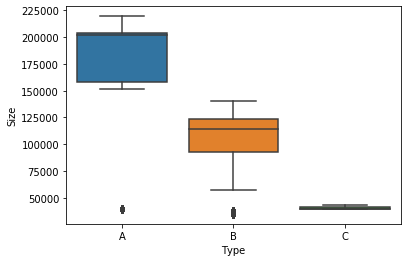

In [19]:
sample_data=pd.concat([df_full['Type'],df_full['Size']],axis=1)
fig=sns.boxplot(x='Type',y='Size',data=sample_data)

Observations
1. We can infer that Store A is the largest and C is the smallest
2. There is no overlapped area in size among A,B,C


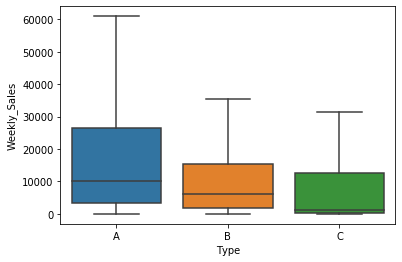

In [20]:
sample_data=pd.concat([df_full['Type'],df_full['Weekly_Sales']],axis=1)
fig=sns.boxplot(x='Type',y='Weekly_Sales',data=sample_data,showfliers=False)

Observations

1. The median of A is the highest and C is the lowest
2. Stores with more sizes have higher sales record

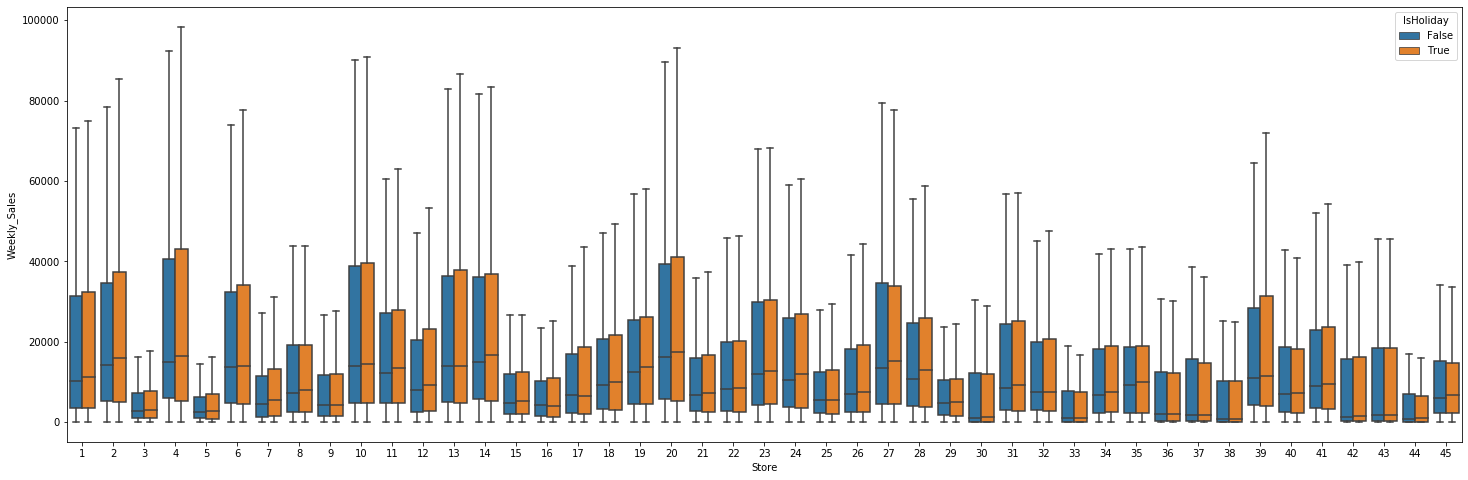

In [21]:
data = pd.concat([df_full['Store'], df_full['Weekly_Sales'], df_full['IsHoliday']], axis=1)
f, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=data, showfliers=False, hue="IsHoliday")

Observations

1. You can see that there is a slight increase in weekly sales on a holiday as compared to non holiday

# Feature Engineering

In [22]:
#encoding for IsHoliday
df_full.IsHoliday=df_full.IsHoliday.astype(int)

In [23]:
#encode Type Feature
le=preprocessing.LabelEncoder().fit(df_full['Type'])

le.classes_

df_full.Type=le.transform(df_full['Type'])

In [24]:
df_full.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,2,2010-02-05,50605.27,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
2,1,3,2010-02-05,13740.12,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
3,1,4,2010-02-05,39954.04,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
4,1,5,2010-02-05,32229.38,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106


In [25]:
#split Date into Day-Month-Year

df_full["day"] = [t.dayofweek for t in pd.DatetimeIndex(df_full.Date)]
df_full["month"] = [t.month for t in pd.DatetimeIndex(df_full.Date)]
df_full['year'] = [t.year for t in pd.DatetimeIndex(df_full.Date)]


In [26]:
df_full.drop("Date",axis=1,inplace=True)

In [27]:
df_full.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,day,month,year
0,1,1,24924.50,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2,2010
1,1,2,50605.27,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2,2010
2,1,3,13740.12,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2,2010
3,1,4,39954.04,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2,2010
4,1,5,32229.38,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2,2010


[]

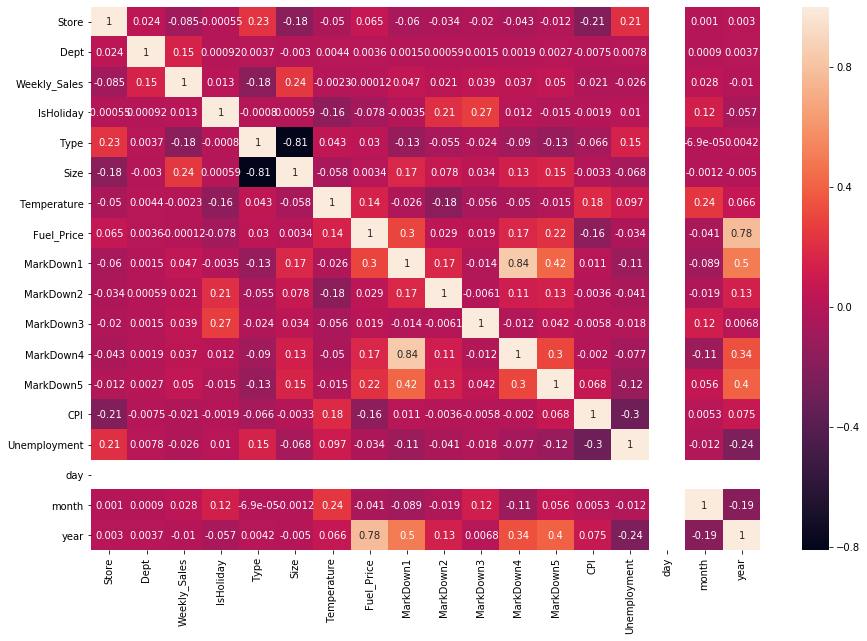

In [28]:
# Plotting correlation between all important features
corr = df_full.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True)
plt.plot()

Observations
1. Not many features are correlated apart from MarkDown1 and MarkDown4 and Fuel_Price and year
2. Size and Type are negative correlated
3. Correlated Features should be deleted

In [29]:
#removing one of the highly correlated features 
df_full=df_full.drop(["MarkDown4","year","Size"],axis=1)

# Machine Learning Models

In [30]:
y=np.array(df_full['Weekly_Sales'])

X=np.array(df_full.drop(['Weekly_Sales'],axis=1))

In [31]:
#train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Random Model

In [32]:
import statistics as st
import itertools
n=np.size(y_train)
y_mean=st.mean(y_train)
y_pred=list(itertools.repeat(y_mean,n))

In [33]:
from sklearn.metrics import median_absolute_error,r2_score
print("MAD Score",median_absolute_error(y_pred,y_train))
print("R2 Score",r2_score(y_pred,y_train))

MAD Score 12576.212896642313
R2 Score -3.166053952252629e+30


https://www.researchgate.net/post/What_is_the_acceptable_R-squared_in_the_information_system_research_Can_you_provide_some_references
The (R-squared) , (also called the coefficient of determination), which is the proportion of variance (%) in the dependent variable that can be explained by the independent variable. Hence, as a rule of thumb for interpreting the strength of a relationship based on its R-squared value (use the absolute value of the R-squared value to make all values positive):
- if  R-squared value < 0.3 this value is generally considered a None or Very weak effect size,
- if R-squared value 0.3 < r < 0.5 this value is generally considered a weak or low effect size,
- if R-squared value 0.5 < r < 0.7 this value is generally considered a Moderate effect size,
- if R-squared value r > 0.7 this value is generally considered strong effect size,
Ref: Source: Moore, D. S., Notz, W. I, & Flinger, M. A. (2013). The basic practice of statistics (6th ed.). New York, NY: W. H. Freeman and Company. Page (138).

Source: Zikmund, William G. (2000). Business research methods (6th ed). Fort Worth: Harcourt College Publishers. (Page 513)

# Linear Regression

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
param_grid={'fit_intercept':[True,False],'normalize':[True,False]}
lr=LinearRegression(n_jobs=-1)
model=GridSearchCV(lr,param_grid,scoring='neg_median_absolute_error',n_jobs=-1,pre_dispatch='2*n_jobs').fit(X_train,y_train)

In [35]:
print("Best Hyperparam Values",model.best_params_)
print("Median cross-validated score ",model.best_score_) 

Best Hyperparam Values {'fit_intercept': False, 'normalize': True}
Median cross-validated score  -9397.077643997307


In [36]:
Lr_model=LinearRegression(fit_intercept=False,normalize=True,n_jobs=-1).fit(X_train,y_train)

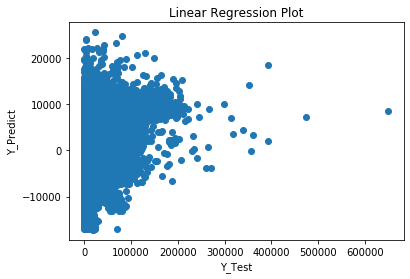

In [37]:
import matplotlib.pyplot as plt
y_pred=Lr_model.predict(X_test)
plt.scatter(y_test,y_pred)
plt.title("Linear Regression Plot")
plt.xlabel("Y_Test")
plt.ylabel("Y_Predict")
plt.show()

In [38]:
from sklearn.metrics import median_absolute_error
print("MAD score : ",median_absolute_error(y_test,y_pred))
print("R2 Score : ",Lr_model.score(X_test,y_test))

MAD score :  9475.04194562693
R2 Score :  -0.4290172445934781


# SGD Regressor

In [39]:
from sklearn.linear_model import SGDRegressor
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
param_grid={'loss':['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'],
'penalty':['l1','l2','elasticnet'],'alpha':[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10],
'learning_rate':['constant','optimal','invscaling','adaptive'] ,        
'early_stopping':[True,False]  }
svm_model=SGDRegressor()
model_svm=GridSearchCV(svm_model,param_grid,scoring='neg_median_absolute_error',n_jobs=-1,pre_dispatch='2*n_jobs').fit(X_train,y_train)

In [40]:
print("Best Hyperparam Values",model_svm.best_params_)
print("Median cross-validated score ",model_svm.best_score_) 

Best Hyperparam Values {'alpha': 0.0001, 'early_stopping': False, 'learning_rate': 'optimal', 'loss': 'huber', 'penalty': 'l2'}
Median cross-validated score  -3993.0208496560035


In [41]:
svm_model=SGDRegressor(alpha=0.0001,early_stopping=False,learning_rate='optimal', loss='huber', penalty= 'l2')
svm_model.fit(X_train,y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='huber', max_iter=None, n_iter=None,
       n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
       shuffle=True, tol=None, validation_fraction=0.1, verbose=0,
       warm_start=False)

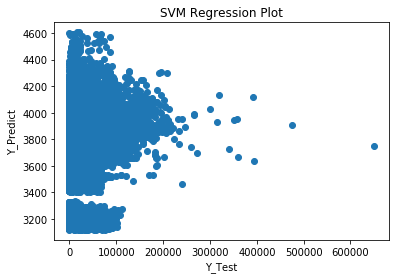

In [42]:
y_pred=svm_model.predict(X_test)
plt.scatter(y_test,y_pred)
plt.title("SVM Regression Plot")
plt.xlabel("Y_Test")
plt.ylabel("Y_Predict")
plt.show()

In [43]:
from sklearn.metrics import median_absolute_error
print("MAD score : ",median_absolute_error(y_test,y_pred))
print("R2 Score : ",svm_model.score(X_test,y_test))

MAD score :  3958.414494333383
R2 Score :  -0.28675177894581694


# Decision Tree Regressor

In [44]:
from sklearn.tree import DecisionTreeRegressor 
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
param_grid={'max_depth':[1,5,10,15,20,25,30],
 'max_features': ['auto', 'sqrt','log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10], }
dt=DecisionTreeRegressor()
model_dt=GridSearchCV(dt,param_grid,scoring='neg_median_absolute_error',n_jobs=-1,pre_dispatch='2*n_jobs').fit(X_train,y_train)

In [45]:
print("Best Hyperparam Values",model_dt.best_params_)
print("Median cross-validated score ",model_dt.best_score_) 

Best Hyperparam Values {'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10}
Median cross-validated score  -679.4970539703062


In [46]:
DTR_model=DecisionTreeRegressor(max_depth=25,max_features='auto',min_samples_leaf=4,min_samples_split=10).fit(X_train,y_train)

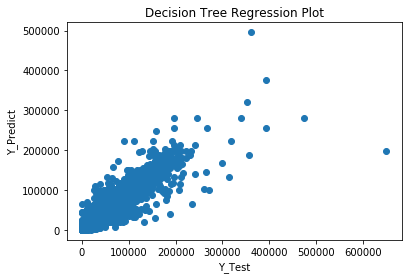

In [47]:
y_pred=DTR_model.predict(X_test)
plt.scatter(y_test,y_pred)
plt.title("Decision Tree Regression Plot")
plt.xlabel("Y_Test")
plt.ylabel("Y_Predict")
plt.show()

In [48]:
from sklearn.metrics import median_absolute_error
print("MAD score : ",median_absolute_error(y_test,y_pred))
print("R2 Score : ",DTR_model.score(X_test,y_test))

MAD score :  648.028086206896
R2 Score :  0.9483482997875317


# Random Forrest Regressor

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
param_grid={'max_depth':[1,5,10,15,20,25,30],'n_estimators':[20,50,100],
  'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10], }
RFR=RandomForestRegressor()
model_rf=RandomizedSearchCV(RFR,param_grid,scoring='neg_median_absolute_error',n_jobs=-1,pre_dispatch='2*n_jobs').fit(X_train,y_train)

In [53]:
print("Best Hyperparam Values",model_rf.best_params_)
print("Median cross-validated score ",model_rf.best_score_) 

Best Hyperparam Values {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30}
Median cross-validated score  -606.8396464037401


In [54]:
random_frgr=RandomForestRegressor(n_estimators=100,min_samples_split=5,min_samples_leaf=2,max_depth=30,n_jobs=-1).fit(X_train,y_train)

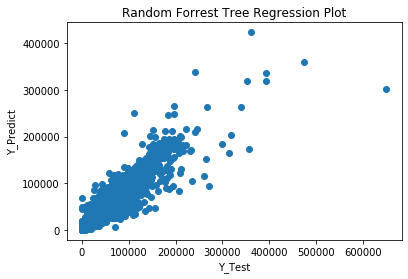

In [55]:
y_pred=random_frgr.predict(X_test)
plt.scatter(y_test,y_pred)
plt.title("Random Forrest Tree Regression Plot")
plt.xlabel("Y_Test")
plt.ylabel("Y_Predict")
plt.show()

In [56]:
from sklearn.metrics import median_absolute_error
print("MAD score : ",median_absolute_error(y_test,y_pred))
print("R2 Score : ",random_frgr.score(X_test,y_test))

MAD score :  573.8513050198385
R2 Score :  0.961994657697324


# Gradient Boosted Regressor

In [57]:
from xgboost import XGBRegressor
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
param_grid={'max_depth':[1,5,10,15,20,25,30],'n_estimators':[20,50,100],'learning_rate':[0.001,0.01,0.1,1]}
xgb=XGBRegressor(n_jobs=-1)
model_rf=RandomizedSearchCV(xgb,param_grid,scoring='neg_median_absolute_error',n_jobs=-1,pre_dispatch='2*n_jobs').fit(X_train,y_train)

[19:13:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [58]:
print("Best Hyperparam Values",model_rf.best_params_)
print("Median cross-validated score ",model_rf.best_score_) 

Best Hyperparam Values {'n_estimators': 100, 'max_depth': 25, 'learning_rate': 0.1}
Median cross-validated score  -597.3653972260108


In [59]:
xgbr=XGBRegressor(n_estimators=100,max_depth=25,learning_rate=0.1,n_jobs=-1).fit(X_train,y_train)

[19:23:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


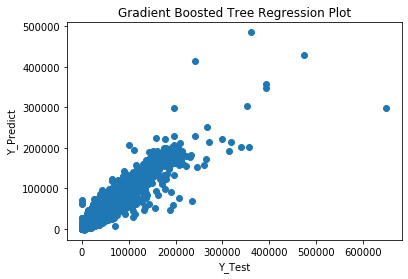

In [60]:
y_pred=xgbr.predict(X_test)
plt.scatter(y_test,y_pred)
plt.title("Gradient Boosted Tree Regression Plot")
plt.xlabel("Y_Test")
plt.ylabel("Y_Predict")
plt.show()

In [61]:
from sklearn.metrics import median_absolute_error
print("MAD score : ",median_absolute_error(y_test,y_pred))
print("R2 Score : ",xgbr.score(X_test,y_test))

MAD score :  554.2575830078131
R2 Score :  0.9664207555102704


# Conclusion

In [63]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x=PrettyTable()
print("Machine Learning Models")
x.field_names=['Model','MAD Score','R2 Score',]
x.add_row(['Random Model',12576.21,-3.166053952252629e+30])
x.add_row(['Linear Regression',9475.04,-0.4290])
x.add_row(['SGD Regressor',3958.41,-0.2867])
x.add_row(['Decision Tree Regressor',648.028,0.9483])
x.add_row(['Random Forrest Regressor',573.85,0.9619])
x.add_row(['Gradient Boosted Regressor',554.25,0.9664])
print(x)

Machine Learning Models
+----------------------------+-----------+------------------------+
|           Model            | MAD Score |        R2 Score        |
+----------------------------+-----------+------------------------+
|        Random Model        |  12576.21 | -3.166053952252629e+30 |
|     Linear Regression      |  9475.04  |         -0.429         |
|       SGD Regressor        |  3958.41  |        -0.2867         |
|  Decision Tree Regressor   |  648.028  |         0.9483         |
|  Random Forrest Regressor  |   573.85  |         0.9619         |
| Gradient Boosted Regressor |   554.25  |         0.9664         |
+----------------------------+-----------+------------------------+
